### Импорты

In [ ]:
# !pip install -q opendatasets
# import opendatasets as od
# !pip install torch_geometric
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from torch_geometric.data import Data
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import random
from IPython.display import HTML
from matplotlib import animation
import torch_geometric.transforms as T
import torch
from torch_geometric.utils import from_networkx, ro_network, to_dense_adj
from sklearn.preprocessing import LabelEncoder

### 1. Сформировать или скачать семантический граф

#### формирование датасета

Данные для входа на kaggle:\
username: alicenet\
key: eb38bcb6ad56b21440b7519fbfc6f0fa


In [ ]:
od.download("https://www.kaggle.com/datasets/kenshoresearch/kensho-derived-wikimedia-data/data", files=['item.csv', 'statements.csv'], force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alicenet
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kenshoresearch/kensho-derived-wikimedia-data


100%|██████████| 8.16G/8.16G [06:34<00:00, 22.2MB/s]


In [ ]:
statements = pd.read_csv('/content/kensho-derived-wikimedia-data/statements.csv')
statements.head()

,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
2,1,398,497745
3,1,398,1133705
4,1,398,1139177


In [ ]:
item = pd.read_csv('/content/kensho-derived-wikimedia-data/item.csv')

In [ ]:
item.head()

,item_id,en_label,en_description
0,1,Universe,totality of space and all contents
1,2,Earth,third planet from the Sun in the Solar System
2,3,life,matter capable of extracting energy from the e...
3,4,death,permanent cessation of vital functions
4,5,human,"common name of Homo sapiens, unique extant spe..."


In [ ]:
filtered_statements = statements.loc[(statements['target_item_id'].isin([11424, 7889, 11410, 571]))]
filtered_statements

,source_item_id,edge_property_id,target_item_id
26542,372,31,11424
34873,593,31,11424
34922,595,31,11424
76300,1365,31,11424
102013,2201,31,11424
...,...,...,...
141160246,77212038,31,7889
141161780,77213805,31,11424
141169453,77221786,31,11424
141176272,77229509,31,7889


In [ ]:
filtered_statements = filtered_statements.loc[(filtered_statements['edge_property_id'].isin([31]))]

In [ ]:
filtered_statements.to_csv('other_targets.csv')

In [ ]:
def add_link(value):
    return 'https://www.wikidata.org/wiki/Q' + str(value)

In [ ]:
filtered_statements['source_link'] = filtered_statements['source_item_id'].apply(add_link)
merged_table = pd.merge(filtered_statements, item, left_on='source_item_id', right_on='item_id', how='left')
merged_table.drop(columns=['source_item_id'], inplace=True)
merged_table.rename(columns={'en_label': 'source_name', 'en_description': 'source_description'}, inplace=True)
merged_table = pd.merge(merged_table, item, left_on='target_item_id', right_on='item_id', how='left')
merged_table.drop(columns=['target_item_id', 'item_id_x', 'item_id_y'], inplace=True)
merged_table.rename(columns={'en_label': 'target_name', 'en_description': 'target_description'}, inplace=True)

In [ ]:
merged_table

,Unnamed: 0,edge_property_id,source_link,target_link,source_name,source_description,target_name,target_description
0,26542,31,https://www.wikidata.org/wiki/Q372,https://www.wikidata.org/wiki/Q11424,We Live in Public,2009 documentary film by Ondi Timoner which pr...,film,sequence of images that give the impression of...
1,34873,31,https://www.wikidata.org/wiki/Q593,https://www.wikidata.org/wiki/Q11424,A Gang Story,2011 film by Olivier Marchal,film,sequence of images that give the impression of...
2,34922,31,https://www.wikidata.org/wiki/Q595,https://www.wikidata.org/wiki/Q11424,The Intouchables,2011 French film directed by Olivier Nakache a...,film,sequence of images that give the impression of...
3,76300,31,https://www.wikidata.org/wiki/Q1365,https://www.wikidata.org/wiki/Q11424,Swept Away,1974 film by Lina Wertmüller,film,sequence of images that give the impression of...
4,102013,31,https://www.wikidata.org/wiki/Q2201,https://www.wikidata.org/wiki/Q11424,Kick-Ass,2010 film by Matthew Vaughn,film,sequence of images that give the impression of...
...,...,...,...,...,...,...,...,...
325680,141160246,31,https://www.wikidata.org/wiki/Q77212038,https://www.wikidata.org/wiki/Q7889,Super Scrapped Robot,"Arcade video game, 2014",video game,electronic game that involves interaction with...
325681,141161780,31,https://www.wikidata.org/wiki/Q77213805,https://www.wikidata.org/wiki/Q11424,NaN,NaN,film,sequence of images that give the impression of...
325682,141169453,31,https://www.wikidata.org/wiki/Q77221786,https://www.wikidata.org/wiki/Q11424,Grosse Pointe Blank,a 1997 dark comedy film starring John and Joan...,film,sequence of images that give the impression of...
325683,141176272,31,https://www.wikidata.org/wiki/Q77229509,https://www.wikidata.org/wiki/Q7889,Quest,Acorn BBC/Electron Cass. ; 198? AUCBE,video game,electronic game that involves interaction with...


#### предобработка данных

In [ ]:
merged_table = pd.read_csv('finished_other.csv')
merged_table.head()

,Unnamed: 0.1,Unnamed: 0,edge_property_id,source_link,source_name,source_description,target_name,target_description
0,0,26542,31,https://www.wikidata.org/wiki/Q372,We Live in Public,2009 documentary film by Ondi Timoner which pr...,film,sequence of images that give the impression of...
1,1,34873,31,https://www.wikidata.org/wiki/Q593,A Gang Story,2011 film by Olivier Marchal,film,sequence of images that give the impression of...
2,2,34922,31,https://www.wikidata.org/wiki/Q595,The Intouchables,2011 French film directed by Olivier Nakache a...,film,sequence of images that give the impression of...
3,3,74229,31,https://www.wikidata.org/wiki/Q1293,draughts,board game,game,recreative activity
4,4,76300,31,https://www.wikidata.org/wiki/Q1365,Swept Away,1974 film by Lina Wertmüller,film,sequence of images that give the impression of...


In [ ]:
merged_table.drop(merged_table.columns[[0, 1, 2, 7]], axis=1, inplace=True)
merged_table = merged_table.dropna()

In [ ]:
def clean_text(text):
  text = re.sub(r'\b\w{1,2}\b', '', text)
  text = text.lower()
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [ ]:
cols_to_clean = merged_table.columns.difference(['target_name', 'source_link'])
merged_table[cols_to_clean] = merged_table[cols_to_clean].applymap(clean_text)
merged_table.head()

,source_link,source_name,source_description,target_name
0,https://www.wikidata.org/wiki/Q372,live public,2009 documentary film ondi timoner which profi...,film
1,https://www.wikidata.org/wiki/Q593,gang story,2011 film olivier marchal,film
2,https://www.wikidata.org/wiki/Q595,the intouchables,2011 french film directed olivier nakache and ...,film
3,https://www.wikidata.org/wiki/Q1293,draughts,board game,game
4,https://www.wikidata.org/wiki/Q1365,swept away,1974 film lina wertmüller,film


In [ ]:
def extract_year(text):
    match = re.search(r'\b(19|20)\d{2}\b', text)
    if match:
        return int(match.group(0))
    return None

In [ ]:
merged_table['year'] = merged_table['source_description'].apply(extract_year)
merged_table = merged_table.dropna()
merged_table.head()

,source_link,source_name,source_description,target_name,year
0,https://www.wikidata.org/wiki/Q372,live public,2009 documentary film ondi timoner which profi...,film,2009.0
1,https://www.wikidata.org/wiki/Q593,gang story,2011 film olivier marchal,film,2011.0
2,https://www.wikidata.org/wiki/Q595,the intouchables,2011 french film directed olivier nakache and ...,film,2011.0
4,https://www.wikidata.org/wiki/Q1365,swept away,1974 film lina wertmüller,film,1974.0
5,https://www.wikidata.org/wiki/Q2201,kick-ass,2010 film matthew vaughn,film,2010.0


In [ ]:
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179104 entries, 0 to 221975
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   source_link         179104 non-null  object 
 1   source_name         179104 non-null  object 
 2   source_description  179104 non-null  object 
 3   target_name         179104 non-null  object 
 4   year                179104 non-null  float64
dtypes: float64(1), object(4)
memory usage: 8.2+ MB


In [ ]:
merged_table['target_name'].value_counts()

target_name
film          155484
video game     17991
book            5608
game              21
Name: count, dtype: int64

In [ ]:
grouped = merged_table.groupby('target_name')
def take_n_percent(group):
  if group['target_name'].iloc[0] == 'book':
    return group.sample(frac=1)
  elif group['target_name'].iloc[0] == 'film':
    return group.sample(frac=0.03)
  elif group['target_name'].iloc[0] == 'video game':
    return group.sample(frac=0.3)
df = grouped.apply(take_n_percent)
df.reset_index(drop=True, inplace=True)

In [ ]:
df = df.sample(frac=0.2, random_state=12)

In [ ]:
df['target_name'].value_counts()

target_name
video game    1113
book          1095
film           926
Name: count, dtype: int64

In [ ]:
df.head()

,source_link,source_name,source_description,target_name,year
5344,https://www.wikidata.org/wiki/Q73518547,scotland' castles,book published 2005,book,2005.0
6500,https://www.wikidata.org/wiki/Q7902072,usne kaha tha,1960 film moni bhattacharjee,film,1960.0
4807,https://www.wikidata.org/wiki/Q6075483,"sex necessary? , why you feel the way you",1929 work james thurber and . . white,book,1929.0
2453,https://www.wikidata.org/wiki/Q54643182,money metropolis: locational study financial a...,"robbins, sidney . terleckyj, nestor . - 1960",book,1960.0
14320,https://www.wikidata.org/wiki/Q5305262,dragon rage,2001 video game,video game,2001.0


#### Граф

In [ ]:
df = df.drop_duplicates(subset=['source_name'])

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['source_name'])
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
print(cosine_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
G = nx.Graph()
for _, row in df.iterrows():
  G.add_node(row['source_name'], link=row['source_link'], description=row['source_description'], year=row['year'], target=row["target_name"])

In [ ]:
threshold = 0.2

for i in range(len(df)):
  for j in range(i + 1, len(df)):
    if cosine_sim[i, j] > threshold:
      G.add_edge(list(G.nodes)[i], list(G.nodes)[j])

In [ ]:
print(G.edges)
print(G.number_of_edges())
print(len(G.nodes))

[("scotland' castles", 'crusader castles and modern histories'), ("scotland' castles", 'norman castles britain'), ("scotland' castles", 'castles the princes gwynedd'), ("scotland' castles", 'the david & charles book castles'), ("scotland' castles", 'castles europe: from charlemagne the renaissance'), ("scotland' castles", 'northern england and southern scotland the central middle ages'), ("scotland' castles", 'buckton castle and the castles north west england'), ("scotland' castles", 'castles'), ("scotland' castles", 'castles cumbria'), ("scotland' castles", 'timber castles'), ("scotland' castles", 'the historic architecture scotland'), ("scotland' castles", 'the early norman castles the british isles'), ("scotland' castles", 'castles britain'), ("scotland' castles", 'english medieval castles'), ("scotland' castles", 'the medieval castles ireland'), ("scotland' castles", 'castles britain and ireland'), ("scotland' castles", 'robert bruce & the community the realm scotland'), ("scotland

In [ ]:
def set_color(target):
  if target == "film":
    return 'blue'
  elif target == 'video game':
    return 'red'
  elif target == 'book':
    return 'green'
  else:
    return 'orange'

In [ ]:
def get_plt(G):
  pos = nx.fruchterman_reingold_layout(G, k=0.5)
  edge_traces = []
  for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace = go.Scatter(
      x=[x0, x1, None],
      y=[y0, y1, None],
      mode='lines',
      line=dict(width=0.1, color='gray'),
      hoverinfo='none'
    )
    edge_traces.append(edge_trace)

  node_trace = go.Scatter(
    x=[pos[node][0] for node in G.nodes()],
    y=[pos[node][1] for node in G.nodes()],
    mode='markers+text',
    marker=dict(size=10, color=[set_color(G.nodes[node]["target"]) for node in G.nodes()]),
    text=[node for node in G.nodes()],
    hovertext=[f'Title: {node}\nYear of release: {G.nodes[node]["year"]}\n Description: {G.nodes[node]["description"]}\nLink:{G.nodes[node]["link"]}' for node in G.nodes()],
    textposition='top center',
    textfont=dict(size=7)
  )

  layout = go.Layout(
    title='Knowledge Graph',
    titlefont_size=16,
    title_x=0.5,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis_visible=False,
    yaxis_visible=False
  )

  fig = go.Figure(data=edge_traces + [node_trace], layout=layout)
  fig.write_html("knowledge_graph.html")
  fig.show()

In [ ]:
get_plt(G)

In [ ]:
def get_description(node_name):
  print(f'Title of document: {node_name}\n' +
  f'Year of release: {int(G.nodes[node_name]["year"])}\n'
  f'Descrtiption: {G.nodes[node_name]["description"]}\n' +
  f'Link: {G.nodes[node_name]["link"]}\n' +
  f'Also similar: {list(G.neighbors(node_name))}')

In [ ]:
def year_published(year):
  nodes_with_attribute = []
  for node in G.nodes():
    if year == int(G.nodes[node]['year']):
      nodes_with_attribute.append(node)
  print(f"Published in {year}: {nodes_with_attribute}")

In [ ]:
get_description('terminator: resistance')

Title of document: terminator: resistance
Year of release: 2019
Descrtiption: 2019 first-person shooter action video game developed teyon
Link: https://www.wikidata.org/wiki/Q68888832
Also similar: ['terminator : war the machines', 'the foscolo lombardi archive preserved the historical institute the resistance tuscany', 'terminator : judgment day', 'invizimals: the resistance']


In [ ]:
get_description('the lego movie videogame')

Title of document: the lego movie videogame
Year of release: 2019
Descrtiption: 2019 video game
Link: https://www.wikidata.org/wiki/Q60220853
Also similar: ['! animate: the movie', 'the worst movie ever!', 'lego legends chima: speedorz', 'wigstock: the movie', 'lego city undercover', 'ryujin mabuyer the movie: nanatsu mabui', 'palmira - the movie', 'lego star wars: the force awakens', 'street fighter: the movie', 'movie days']


In [ ]:
year_published(2018)

Published in 2018: ['tragedies, volume : oedipus. agamemnon. thyestes. hercules oeta. octavia', 'superclasse mondiale contre les peuples', 'charles maurras : prophète résistant', 'killing', "'été des quatre rois", 'bobby robson: more than manager', 'navigating semi-colonialism: shipping, sovereignty, and nation-building china, 1860–1937', 'paul sanchez est revenu!', 'age conquests: the greek world from alexander hadrian', 'dumbarton oaks papers,', 'voyage indiscret chez les francs-maçons midi', "getting off: one woman' journey through sex and porn addiction", 'feel free', 'jag stannar till slutet', 'joy iran', 'genius', 'space hodsola', 'minecraft: dungeons', 'dynamite!', 'inventing the social', 'the medieval military engineer', 'ace mage: through desert', 'city debtors: century fringe finance', 'mega man legacy collection', 'top incomes france the twentieth century: inequality and redistribution, 1901–1998', 'hope aur hum', 'paradise lost', 'world-class universities: towards global co

### 2. Реализовать модель GCN применительно к этому графу для классификации вершин графа

In [ ]:
vectorizer = TfidfVectorizer()
X_text1 = vectorizer.fit_transform(df['source_name']).toarray()
# X_text2 = vectorizer.fit_transform(df['source_description']).toarray()
# X = np.hstack((X_text1, X_text2))
X = X_text1

In [ ]:
X.shape

(3108, 5891)

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['target_name'])
y.shape

(3108,)

In [ ]:
n = len(G.nodes)

x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=from_networkx(G).edge_index, y=y)

print(data)

<ipython-input-270-0ed68a9df55e>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Data(x=[3108, 5891], edge_index=[2, 14968], y=[3108])


In [ ]:
split = T.RandomNodeSplit(split='train_rest', num_val=0, num_test=700)
data = split(data)
data

Data(x=[3108, 5891], edge_index=[2, 14968], y=[3108], train_mask=[3108], val_mask=[3108], test_mask=[3108])

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(data.num_features, 1024)
        self.out1 = Linear(1024, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.out2 = Linear(128, 3)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out1(h)
        z = self.dropout(z)
        z = self.out2(z)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(5891, 1024)
  (out1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (out2): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
def test():
    model.eval()
    h, z = model(data.x, data.edge_index)
    acc = accuracy(z[data.test_mask].argmax(dim=1), data.y[data.test_mask])
    return acc

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

embeddings = []
losses = []
accuracies = []
test_accuracies = []
outputs = []
for epoch in range(41):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z[data.train_mask], data.y[data.train_mask])
    acc = accuracy(z[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    test_acc = test()
    test_accuracies.append(test_acc)
    outputs.append(z[data.train_mask].argmax(dim=1))
    if epoch%5==0:
      print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}% | Test_Acc: {test_acc*100:.2f}%')

Epoch   0 | Loss: 1.10 | Acc: 30.36% | Test_Acc: 27.71%
Epoch   5 | Loss: 1.05 | Acc: 62.38% | Test_Acc: 54.57%
Epoch  10 | Loss: 0.90 | Acc: 68.98% | Test_Acc: 57.29%
Epoch  15 | Loss: 0.66 | Acc: 79.24% | Test_Acc: 58.43%
Epoch  20 | Loss: 0.45 | Acc: 87.38% | Test_Acc: 59.29%
Epoch  25 | Loss: 0.30 | Acc: 90.53% | Test_Acc: 59.43%
Epoch  30 | Loss: 0.21 | Acc: 92.61% | Test_Acc: 60.00%
Epoch  35 | Loss: 0.16 | Acc: 94.19% | Test_Acc: 59.86%
Epoch  40 | Loss: 0.12 | Acc: 95.81% | Test_Acc: 58.71%


In [ ]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 40, 5), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [ ]:
display(html)

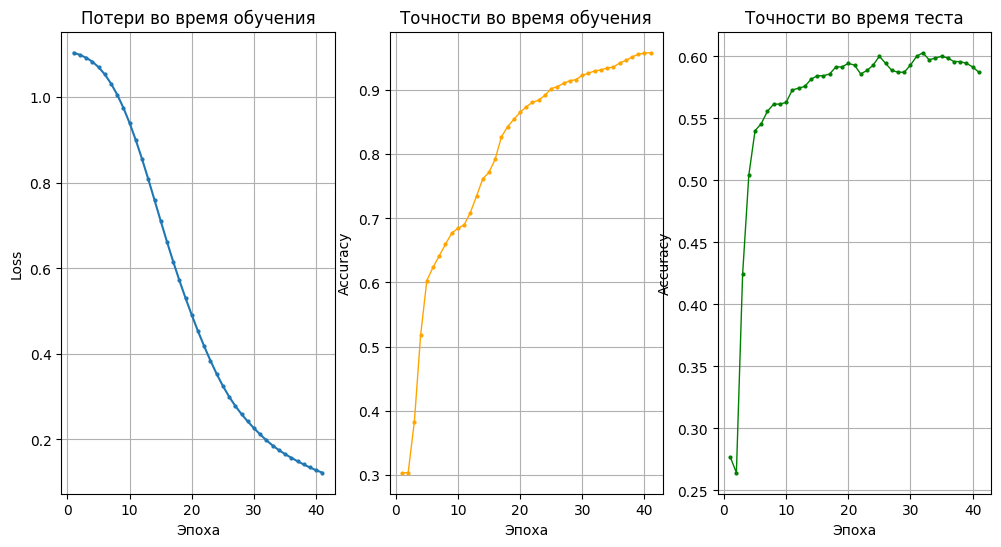

In [ ]:
epochs = list(range(1, len(losses) + 1))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.plot(epochs,  [loss.detach().numpy() for loss in losses], marker='o', linestyle='-', markersize=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('Потери во время обучения')
ax1.grid(True)
ax2.plot(epochs, accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='orange')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('Точности во время обучения')
ax2.grid(True)
ax3.plot(epochs, test_accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='green')
ax3.set_xlabel('Эпоха')
ax3.set_ylabel('Accuracy')
ax3.set_title('Точности во время теста')
ax3.grid(True)
plt.show()

### 3. Сравнить качество полученной модели с другими моделями

In [ ]:
class GraphLinearClassifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(data.num_features, 64)
    self.fc3 = torch.nn.Linear(64, 3)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc3(x)
    return x

model2 = GraphLinearClassifier()
print(model2)

GraphLinearClassifier(
  (fc1): Linear(in_features=5891, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
def test():
    model2.eval()
    out = model2(data.x)
    pred = out[data.test_mask].max(dim=1)[1]
    correct = pred.eq(data.y[data.test_mask])
    acc = correct.sum().item() / len(data.y[data.test_mask])
    return acc

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0002)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

embeddings = []
losses = []
accuracies = []
outputs = []
test_accuracies = []
for epoch in range(41):
    optimizer.zero_grad()
    output = model2(data.x)
    loss = criterion(output[data.train_mask], data.y[data.train_mask])
    acc = accuracy(output[data.train_mask].argmax(dim=1), data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(output[data.train_mask].argmax(dim=1))
    test_acc = test()
    test_accuracies.append(test_acc)
    if epoch % 5 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}% | Test_Acc: {test_acc*100:.2f}%')

Epoch   0 | Loss: 1.10 | Acc: 30.36% | Test_Acc: 27.71%
Epoch   5 | Loss: 1.10 | Acc: 30.44% | Test_Acc: 27.71%
Epoch  10 | Loss: 1.09 | Acc: 46.05% | Test_Acc: 33.86%
Epoch  15 | Loss: 1.09 | Acc: 60.96% | Test_Acc: 45.00%
Epoch  20 | Loss: 1.08 | Acc: 63.95% | Test_Acc: 47.00%
Epoch  25 | Loss: 1.07 | Acc: 64.29% | Test_Acc: 45.86%
Epoch  30 | Loss: 1.07 | Acc: 65.61% | Test_Acc: 43.14%
Epoch  35 | Loss: 1.06 | Acc: 71.55% | Test_Acc: 42.57%
Epoch  40 | Loss: 1.06 | Acc: 80.44% | Test_Acc: 44.43%


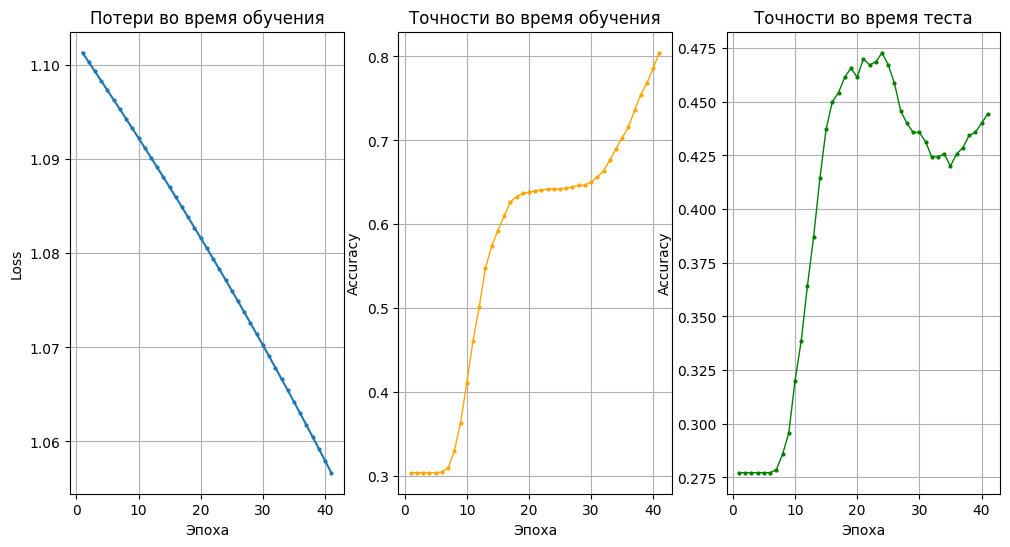

In [ ]:
epochs = list(range(1, len(losses) + 1))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.plot(epochs,  [loss.detach().numpy() for loss in losses], marker='o', linestyle='-', markersize=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('Потери во время обучения')
ax1.grid(True)
ax2.plot(epochs, accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='orange')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy')
ax2.set_title('Точности во время обучения')
ax2.grid(True)
ax3.plot(epochs, test_accuracies, marker='o', linestyle='-', linewidth=1, markersize=2, color='green')
ax3.set_xlabel('Эпоха')
ax3.set_ylabel('Accuracy')
ax3.set_title('Точности во время теста')
ax3.grid(True)
plt.show()